<a href="INSERT_colab_R_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

label: exercise_3
# Exercise 3: Smoothed Cross-Entropy Loss (b)
Implement the smoothed cross-entropy. We provide the signature of the function here as a reference:

In [1]:
#| label: exercise_3_signature
#’ @param label ground truth vector of the form (n_samples,).
#’ Labels should be "1","2","3" and so on.
#’ @param pred Predicted probabilities of the form (n_samples,n_labels)
#’ @param smoothing Hyperparameter for label-smoothing

# You may find useful to use `numpy` library (but you're not required to)
import numpy as np # pip/conda/uv pip install numpy

def smoothed_ce_loss(label: np.ndarray, 
                     pred: np.ndarray, 
                     smoothing: float) -> float:
    return loss

label: solution
# Solution

label: solution_motivation
## Motivation
Before starting the solutions, let's try to develop a feeling for the smoothed cross-entropy loss by plotting it for different values of the smoothing parameter.

In [ ]:
#| label: motivation
import numpy as np
import matplotlib.pyplot as plt

g     = 10                             # number of classes
betas = np.array([0, 0.05, 0.25, 0.5]) # we include 0 to compare with standard CE
n_pts = 1_000                          # resolution of the x-axis


def smoothed_ce(p: np.ndarray, g: int, beta: float) -> np.ndarray:
    eps       = np.finfo(float).eps  # in order to avoid having log(0)
    p_other   = (1 - p) / (g - 1)    # uniform probs for wrong classes
    t_true    = 1 - beta + beta / g  # smoothed target for true class
    t_other   = beta / g             # target for each wrong class

    return -( t_true * np.log(p + eps)
            + (g - 1) * t_other * np.log(p_other + eps) )

# getting the loss for various betas and predicted probabilities
p_vals = np.linspace(0.001, 0.999, num=n_pts) 
loss   = np.stack([smoothed_ce(p_vals, g, b) for b in betas], axis=0)

label: motivation_plotting
### Plotting

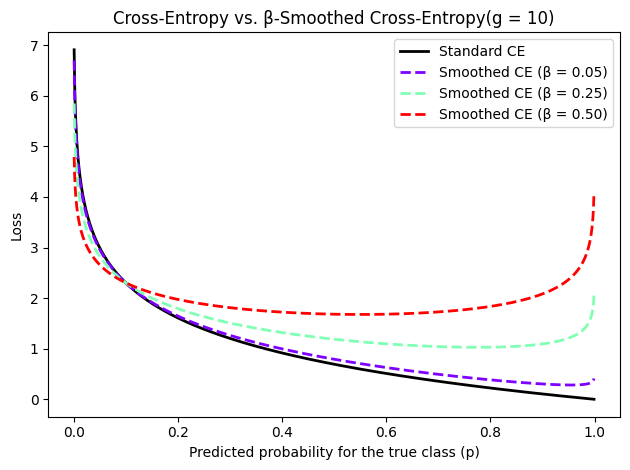

In [11]:
#| label: motivation_plotting
cols = ["black"] + list(plt.cm.rainbow(np.linspace(0, 1, len(betas) - 1)))
ltys = ["solid"] + ["dashed"] * (len(betas) - 1)

plt.figure() 
for idx, (beta, col, lty) in enumerate(zip(betas, cols, ltys)):
    plt.plot(
        p_vals,
        loss[idx],
        color=col,
        linestyle=lty,
        linewidth=2,
        label="Standard CE" if beta == 0 else f"Smoothed CE (β = {beta:.2f})"
    )

plt.xlabel("Predicted probability for the true class (p)")
plt.ylabel("Loss")
plt.title(f"Cross‑Entropy vs. β‑Smoothed Cross‑Entropy(g = {g})")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


label: motivation_interpretation
### Interpretation
We can see that for the standard CE (black line) the loss goes to zero  when the predicted probability for the true class goes to one (over-confident prediction). On the other hand, the smoothed CE (colored lines) takes on comparable values whenever the predicted probabilities are small (e.g before 0.2), but once the predicted probability approaches one, the curves actually go up, and by that penalizing over-confident predictions. The larger the smoothing parameter, the more pronounced this effect is.

label: solution_main
## Main solution

In [21]:
#| label: full_solution
#' @param label ground truth vector of the form (n_samples,).
#'  Labels should be "1","2","3" and so on.
#' @param pred Predicted probabilities of the form (n_samples,n_labels)
#' @param smoothing Hyperparameter for label-smoothing

def smoothed_ce_loss(label: np.ndarray, 
                     pred: np.ndarray, 
                     smoothing: float) -> float:
    print(f"Smoothing coefficient: {smoothing}\n")
	
    num_samples, num_classes = pred.shape

	# Let's make some assertions:
    assert label.ndim == 1, "label should be a 1-D array.one-hot encoded label is not necessary"
    assert 0 <= smoothing <= 1, "smoothing must be in [0, 1]"
    assert len(label) == num_samples, "amount of rows in label and pred must match"
    assert len(np.unique(label)) == num_classes, "Predicted probabilities must have as many columns as labels"

	# Calculate the base level
    smoothing_per_class = smoothing / num_classes

	# build the label matrix. Shape = [ num_samples, num_classes]
	# Start with the base level
    smoothed_labels = np.full((num_samples, num_classes),
                                     smoothing_per_class)
	# Add the smoothed correct labels
    true_labels_loc_row = np.arange(num_samples)
    true_labels_loc_col = label - 1
    smoothed_labels[true_labels_loc_row, 
                    true_labels_loc_col] = 1 - smoothing + smoothing_per_class
    print(f"Labels matrix:\n{smoothed_labels}")

	# Calculate the loss
    per_sample_loss = -np.sum(smoothed_labels * np.log(pred), axis=1)
    print(f"\nLoss for each sample:\n {per_sample_loss}")
    
    loss = per_sample_loss.mean()
    print(f"\nLoss: {loss}\n")
    
    return float(loss)


label: confindent_model
### Confident Model
Let's build a "confident model". The model will have very high predicted probabilities for one of the labels. Additionally, we will add one sample with a not confident prediction (i.e. the predicted probabilities are close to uniform) and see how the smoothed cross-entropy behaves in this case.


In [22]:
label = np.array([1, 2, 2, 3, 1, 1])
pred = np.array([
        (0.85, 0.10, 0.05), # 0.85 for the true label
		(0.05, 0.90, 0.05), # 0.90 ...
		(0.02, 0.95, 0.03), # 0.95
		(0.13, 0.02, 0.85), # 0.85
		(0.86, 0.04, 0.10), # 0.86
        (0.34, 0.33, 0.33)]) # 0.34 (not confident prediction)

# Standard cross entropy (smoothing = 0)
loss = smoothed_ce_loss(label, pred, smoothing=0)

# Smoothed cross entropy (smoothing = 0.2)
loss_smooth = smoothed_ce_loss(label, pred, smoothing=0.2)

print(f"Loss increased by a factor of {round(loss_smooth / loss, 2)} "
    "when using label smoothing with β = 0.2.\n")

Smoothing coefficient: 0

Labels matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]

Loss for each sample:
 [0.16251893 0.10536052 0.05129329 0.16251893 0.15082289 1.07880966]

Loss: 0.28522070335790667

Smoothing coefficient: 0.2

Labels matrix:
[[0.86666667 0.06666667 0.06666667]
 [0.06666667 0.86666667 0.06666667]
 [0.06666667 0.86666667 0.06666667]
 [0.06666667 0.06666667 0.86666667]
 [0.86666667 0.06666667 0.06666667]
 [0.86666667 0.06666667 0.06666667]]

Loss for each sample:
 [0.4940709  0.49074342 0.53902625 0.53766599 0.49881057 1.08279006]

Loss: 0.6071845297686782

Loss increased by a factor of 2.13 when using label smoothing with β = 0.2.



label: solution_interpretation
### Interpretation
We can see that by adding smoothing we have changed the labels matrix (1's have decrease to 0.86 and zeros ent up to 0.06) which resulted in average loss increased from ~0.29 to ~0.61 (~2.13x increase).

Let's observe the changes in the loss for each sample:
| Sample ID | Prediction distribution  | Prediction true label | Standard | Smoothed CE | Change factor |
| :-------: | -------------------------------------- | :------: | ---------: | ----------: | ------------: |
|     1     | (0.850, 0.100, 0.050)                  |   0.85  |      0.163 |       0.494 |         3.040 |
|     2     | (0.050, 0.900, 0.050)                  |   0.90  |      0.105 |       0.491 |         4.658 |
|     3     | (0.020, 0.950, 0.030)                  |   0.95  |      0.051 |       0.539 |        10.509 |
|     4     | (0.130, 0.020, 0.850)                  |   0.85  |      0.163 |       0.538 |         3.308 |
|     5     | (0.860, 0.040, 0.100)                  |   0.86  |      0.151 |       0.499 |         3.307 |
|     6     | (0.340, 0.330, 0.330)                  |   0.34  |      1.079 |       1.083 |         1.004 |

We can observe that the loss for the not confident prediction (sample 6) has remained practically unchanged, but for the confident predictions (samples 1-5) the loss has increased significantly. The increase is especially noticeable for the 3rd sample, for which the prediction was very confident (0.95) and the loss has increased by a factor of 10.5.